# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import math
from reduce_mem_usage import reduce_mem_usage
import glob

# Japanese font setting
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

import xgboost as xgb
import pickle

# enlarge plot
# plt.rcParams['figure.figsize'] = (20, 7)

# HOUR = 1
HOUR = 24

CLASSIFIER = 'xgboost'

TARGET = 'outcome1'
# TARGET = 'dos_within_1d'
# TARGET = 'dos_within_2d'
# TARGET = 'dos_within_3d'
# TARGET = 'dos_within_1w'
# TARGET = 'dos_more_2w'

DROP_SOFA_APACHE = False

FEATURE = None
# FEATURE = ['SOFA_score', 'apache2_score', 'apache2_est_mortality']
# FEATURE = ['SOFA_score']
# FEATURE = ['apache2_score']
# FEATURE = ['apache2_est_mortality']

# read data

In [2]:
index_col = ['pID','Ent_datetime']

X_train = []
y_train = []
X_test = []
y_test = []

for i in range(10):
    # train
    if TARGET == 'outcome1':
        file_train = '../../../data/patient/imputation4/outcome1_train_{}h_{}.txt'.format(HOUR, i)
        file_test = '../../../data/patient/imputation4/outcome1_test_{}h_{}.txt'.format(HOUR, i)
    else:
        file_train = '../../../data/patient/imputation4/days_of_stay_train_{}h_{}.txt'.format(HOUR, i)
        file_test = '../../../data/patient/imputation4/days_of_stay_test_{}h_{}.txt'.format(HOUR, i)

    df_train = pd.read_table(file_train, low_memory=False, index_col=index_col)
    df_test = pd.read_table(file_test, low_memory=False, index_col=index_col)
    
    if TARGET == 'outcome1':
        del_cols = ['dos_within_1d', 'dos_within_2d', 'dos_within_3d', 'dos_within_1w', 'dos_more_2w']
        df_train.drop(del_cols,axis=1,inplace=True)
        df_test.drop(del_cols,axis=1,inplace=True)
    elif TARGET != 'outcome1':
        del_cols = ['dos_within_1d', 'dos_within_2d', 'dos_within_3d', 'dos_within_1w', 'dos_more_2w']
        del_cols.remove(TARGET)
        df_train.drop(del_cols,axis=1,inplace=True)
        df_test.drop(del_cols,axis=1,inplace=True)

    # print(df_train.columns.values)

    if DROP_SOFA_APACHE:
        drop_cols = ['SOFA_score','apache2_score','apache2_est_mortality']
        df_train.drop(drop_cols,axis=1,inplace=True)
        df_test.drop(drop_cols,axis=1,inplace=True)

    if FEATURE is not None:
        df_train = df_train[[TARGET] + FEATURE]
        df_test = df_test[[TARGET] + FEATURE]

    X_train.append(df_train.drop(TARGET,axis=1))
    y_train.append(df_train[TARGET])
    X_test.append(df_test.drop(TARGET,axis=1))
    y_test.append(df_test[TARGET])

# train

In [3]:
def train(i):    
    if TARGET == 'outcome1':
        params = {
            'base_score': 0.5,
            'booster': 'gbtree',
            'colsample_bylevel': 1,
            'colsample_bynode': 1,
            'colsample_bytree': 1,
            'gamma': 0,
            'learning_rate': 0.1,
            'max_delta_step': 0,
            'max_depth': 10,
            'min_child_weight': 1,
            'missing': None,
            'n_estimators': 1000,
            'n_jobs': 6,
            'nthread': None,
            'objective': 'binary:logistic',
            'random_state': i,
            'reg_alpha': 1,
            'reg_lambda': 1,
            'scale_pos_weight': 1,
            'seed': None,
            'silent': None,
            'subsample': 0.9,
            'verbosity': 2,
        }
    elif TARGET == 'dos_within_1d':
        params = {
            'base_score': 0.5,
            'booster': 'gbtree',
            'colsample_bylevel': 1,
            'colsample_bynode': 1,
            'colsample_bytree': 1,
            'gamma': 0,
            'learning_rate': 0.1,
            'max_delta_step': 0,
            'max_depth': 6,
            'min_child_weight': 1,
            'missing': None,
            'n_estimators': 1000,
            'n_jobs': 6,
            'nthread': None,
            'objective': 'binary:logistic',
            'random_state': i,
            'reg_alpha': 0,
            'reg_lambda': 1,
            'scale_pos_weight': 1,
            'seed': None,
            'silent': None,
            'subsample': 0.9,
            'verbosity': 1
        }
    elif TARGET == 'dos_within_2d':
        params = {
            'base_score': 0.5,
            'booster': 'gbtree',
            'colsample_bylevel': 1,
            'colsample_bynode': 1,
            'colsample_bytree': 1,
            'gamma': 0,
            'learning_rate': 0.1,
            'max_delta_step': 0,
            'max_depth': 6,
            'min_child_weight': 1,
            'missing': None,
            'n_estimators': 1000,
            'n_jobs': 6,
            'nthread': None,
            'objective': 'binary:logistic',
            'random_state': i,
            'reg_alpha': 0,
            'reg_lambda': 1,
            'scale_pos_weight': 1,
            'seed': None,
            'silent': None,
            'subsample': 0.9,
            'verbosity': 1
        }
    elif TARGET == 'dos_within_3d':
        params = {
            'base_score': 0.5,
            'booster': 'gbtree',
            'colsample_bylevel': 1,
            'colsample_bynode': 1,
            'colsample_bytree': 1,
            'gamma': 0,
            'learning_rate': 0.1,
            'max_delta_step': 0,
            'max_depth': 10,
            'min_child_weight': 1,
            'missing': None,
            'n_estimators': 1000,
            'n_jobs': 6,
            'nthread': None,
            'objective': 'binary:logistic',
            'random_state': i,
            'reg_alpha': 0,
            'reg_lambda': 1,
            'scale_pos_weight': 1,
            'seed': None,
            'silent': None,
            'subsample': 0.9,
            'verbosity': 1
        }
    elif TARGET == 'dos_within_1w':
        params = {
            'base_score': 0.5,
            'booster': 'gbtree',
            'colsample_bylevel': 1,
            'colsample_bynode': 1,
            'colsample_bytree': 1,
            'gamma': 0,
            'learning_rate': 0.1,
            'max_delta_step': 0,
            'max_depth': 6,
            'min_child_weight': 1,
            'missing': None,
            'n_estimators': 1000,
            'n_jobs': 6,
            'nthread': None,
            'objective': 'binary:logistic',
            'random_state': i,
            'reg_alpha': 1,
            'reg_lambda': 1,
            'scale_pos_weight': 1,
            'seed': None,
            'silent': None,
            'subsample': 0.9,
            'verbosity': 1
        }
    elif TARGET == 'dos_more_2w':
        params = {
            'base_score': 0.5,
            'booster': 'gbtree',
            'colsample_bylevel': 1,
            'colsample_bynode': 1,
            'colsample_bytree': 1,
            'gamma': 0,
            'learning_rate': 0.1,
            'max_delta_step': 0,
            'max_depth': 10,
            'min_child_weight': 1,
            'missing': None,
            'n_estimators': 1000,
            'n_jobs': 6,
            'nthread': None,
            'objective': 'binary:logistic',
            'random_state': i,
            'reg_alpha': 0,
            'reg_lambda': 1,
            'scale_pos_weight': 1,
            'seed': None,
            'silent': None,
            'subsample': 0.9,
            'verbosity': 1
        }
        
    model = xgb.XGBClassifier(**params)
    
    model.fit(X_train[i], np.array(y_train[i]))
    
    return model
    
model = []
for i in range(10):
    model.append(train(i))

# grid search

In [4]:
from sklearn.model_selection import GridSearchCV

if False:
    # scoring = 'accuracy'
    scoring = 'roc_auc'

    params = {
        'base_score': [0.5],
        'booster': ['gbtree'],
        'colsample_bylevel': [1],
        'colsample_bynode': [1],
        'colsample_bytree': [1],
        'gamma': [0], #[0,10,50],
        'learning_rate': [0.1],
        'max_delta_step': [0],
        'max_depth': [10], #[6, 10],
        'min_child_weight': [1],
        'missing': [None],
        'n_estimators': [200],
        'n_jobs': [6],
        'nthread': [None],
        'objective': ['binary:logistic'],
        'random_state': [1],
        'reg_alpha': [0,1],
        'reg_lambda': [1],
        'scale_pos_weight': [1], #[1, 25, 50],
        'seed': [None],
        'silent': [None],
        'subsample': [0.3, 0.5, 0.7, 0.9, 1],
        'verbosity': [1]
    }

    gs = GridSearchCV(xgb.XGBClassifier(), params, scoring=scoring, verbose=2)
    gs.fit(X_train, y_train)

    gs_result = pd.DataFrame.from_dict(gs.cv_results_)
    model = gs.best_estimator_

#     gs_result.to_csv('../../../data/patient/union_outcome1/result/grid_search_result_outcome1_{}_group{}.txt'.format(CLASSIFIER, GROUP_NO), sep='\t', index=False)
#     pickle.dump(model, open('../../../data/patient/union_outcome1/result/model_outcome1_{}_group{}.pickle'.format(CLASSIFIER, GROUP_NO), 'wb'))

#     pred = model.predict(X_test)

    gs_result

# importance

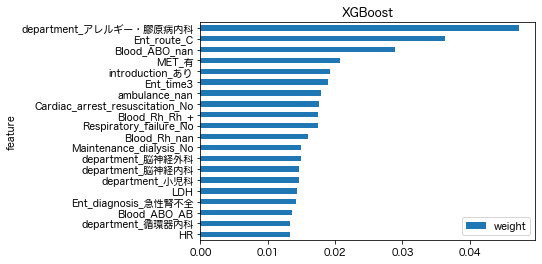

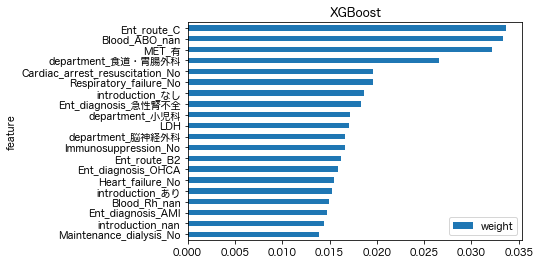

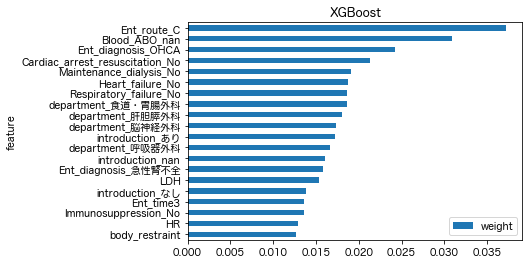

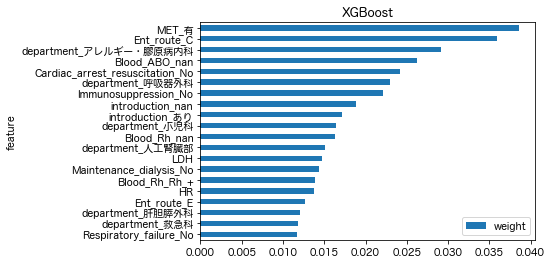

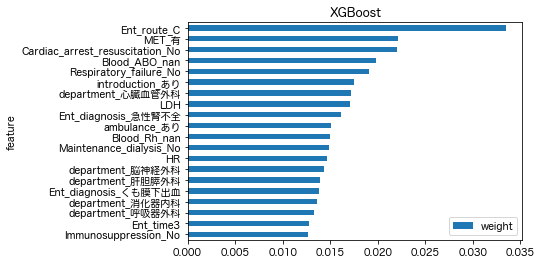

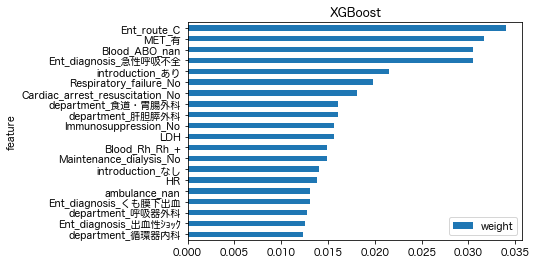

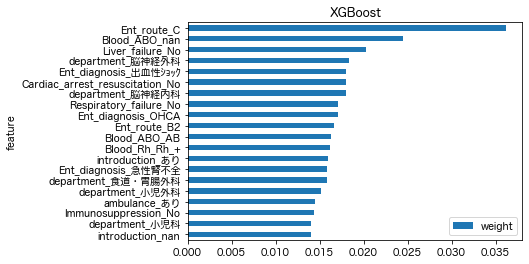

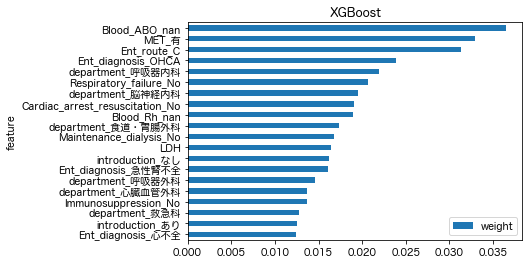

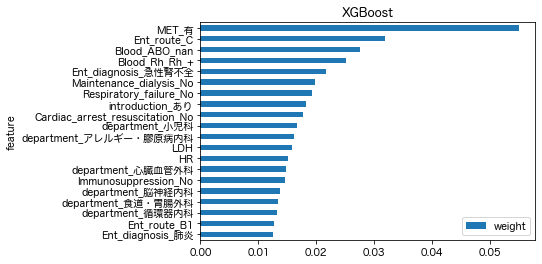

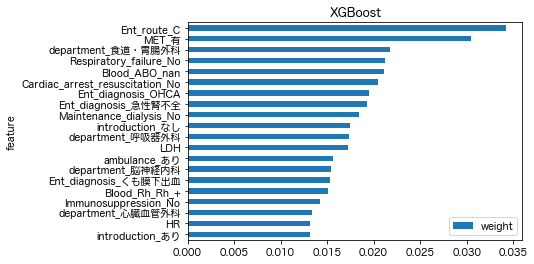

In [5]:
IMPORTANCES_BASE = '../../../data/patient/imputation4/result/variable_importances/{}_{}_{}h'\
    .format(TARGET, CLASSIFIER, HOUR)

def importance(i):
    df_feature = pd.DataFrame(X_train[i].columns, columns=['feature'])
    df_weight = pd.DataFrame(model[i].feature_importances_, columns=['weight'])
    df_importance = pd.concat([df_feature, df_weight],axis=1).sort_values('weight', ascending=False)

    df_importance.to_csv('{}/variable_importances_{}_{}_{}h_{}.txt'\
        .format(IMPORTANCES_BASE,TARGET, CLASSIFIER, HOUR, i), sep='\t', index=False)
    df_importance.head(20).sort_values('weight').plot.barh(x='feature', y='weight',title='XGBoost')

for i in range(10):
    importance(i)

In [6]:
# get mean
files = glob.glob('{}/*'.format(IMPORTANCES_BASE))
files.sort()

df_total = pd.DataFrame()
for f in files:
    if f.endswith('_mean.txt'):
        continue
    print(f.split('/')[-1])
    df_ = pd.read_table(f, sep='\t')
    df_total = pd.concat([df_total, df_], axis=0)

df_mean = df_total.groupby('feature', as_index=False).mean().sort_values('weight', ascending=False)
df_mean.to_csv('{}/variable_importances_{}_{}_{}h_mean.txt'\
    .format(IMPORTANCES_BASE,TARGET, CLASSIFIER, HOUR), sep='\t', index=False)

variable_importances_dos_more_2w_xgboost_24h_0.txt
variable_importances_dos_more_2w_xgboost_24h_1.txt
variable_importances_dos_more_2w_xgboost_24h_2.txt
variable_importances_dos_more_2w_xgboost_24h_3.txt
variable_importances_dos_more_2w_xgboost_24h_4.txt
variable_importances_dos_more_2w_xgboost_24h_5.txt
variable_importances_dos_more_2w_xgboost_24h_6.txt
variable_importances_dos_more_2w_xgboost_24h_7.txt
variable_importances_dos_more_2w_xgboost_24h_8.txt
variable_importances_dos_more_2w_xgboost_24h_9.txt


# ROC

AUC= 0.8781914134930824
AUC= 0.8872693141192872
AUC= 0.8767420781168763
AUC= 0.8855807233793901
AUC= 0.8709447366120521
AUC= 0.8883965749674475
AUC= 0.8730290189149769
AUC= 0.8829765207669054
AUC= 0.8784398709861462
AUC= 0.8819044726949816
AUC 95% CI= [0.8714137  0.88814294]


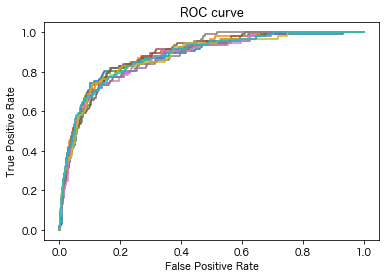

In [7]:
from sklearn import metrics
from sklearn.metrics import roc_curve

ROC_BASE = '../../../data/patient/imputation4/result/roc/{}_{}_{}h'\
    .format(TARGET, CLASSIFIER, HOUR)

def roc(i):
    pp = model[i].predict_proba(X_test[i])[:,1]
    fpr, tpr, threshold = roc_curve(y_test[i].values, pp)

    # save roc data
    df_roc = pd.DataFrame(y_test[i])
    df_roc.columns = ['test']
    df_roc['predict'] = pp
    df_roc.to_csv('{}/roc_{}_{}_{}h_{}.txt'
        .format(ROC_BASE,TARGET, CLASSIFIER, HOUR, i), sep='\t', index=False)

    # AUC
    auc = metrics.auc(fpr, tpr)
    print('AUC=', auc)

    # ROC curve
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    return auc

auc_list = []
for i in range(10):
    auc_list.append(roc(i))

print('AUC 95% CI= {}'.format(np.percentile(auc_list, (2.5, 97.5))))

In [8]:
# get mean
files = glob.glob('{}/*'.format(ROC_BASE))
files.sort()

df_total = pd.DataFrame()
for f in files:
    if f.endswith('_mean.txt'):
        continue
    print(f.split('/')[-1])
    df_ = pd.read_csv(f, sep='\t')
    df_total = pd.concat([df_total, df_], axis=0)

df_mean = df_total.reset_index().groupby('index', as_index=False).mean().drop('index',axis=1)
df_mean.to_csv('{}/roc_{}_{}_{}h_mean.txt'\
    .format(ROC_BASE,TARGET, CLASSIFIER, HOUR), sep='\t', index=False)


roc_dos_more_2w_xgboost_24h_0.txt
roc_dos_more_2w_xgboost_24h_1.txt
roc_dos_more_2w_xgboost_24h_2.txt
roc_dos_more_2w_xgboost_24h_3.txt
roc_dos_more_2w_xgboost_24h_4.txt
roc_dos_more_2w_xgboost_24h_5.txt
roc_dos_more_2w_xgboost_24h_6.txt
roc_dos_more_2w_xgboost_24h_7.txt
roc_dos_more_2w_xgboost_24h_8.txt
roc_dos_more_2w_xgboost_24h_9.txt


# get_params

In [15]:
model[1].get_params()


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'n_jobs': 6,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.9,
 'verbosity': 1}